## **Compositional Kernel Search for Gaussian Processes**

Despite its importance, choosing the right covariance kernel to use with a Gaussian Process model can be a difficult task. For example, when modelling long-term historical data, one may be interested in local seasonal effects (short-term periodic parts of the signal), as well as long-term global trends.

In addition to the commonly chosen kernel functions, the space of possible kernels become very complicated when including _compositional kernels_, such as adding or multiplying two kernels together. For a brief reference on compositional kernels, see [here](https://www.cs.toronto.edu/~duvenaud/cookbook/).

The `twinlab` library comes with a feature called _Model Selection_ which automates the process of kernel selection and composition. This algorithm is a mix of two well-known algorithms: [Compositional Kernel Search](https://arxiv.org/pdf/1302.4922.pdf) and [Scalable Structure Discovery](http://proceedings.mlr.press/v84/kim18a/kim18a.pdf).

This notebook will cover:

- Compositional Kernel Search in `Emulator`


In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinlab import
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.10.0
          User        : alexander@digilab.co.uk
          Server      : https://twinlab.digilab.co.uk/v3
          Environment : /Users/mead/digiLab/twinLab/tutorials/.env



### **Problem Formulation**

Here, we will design a function with multiple components that may be interest for modelling purposes.


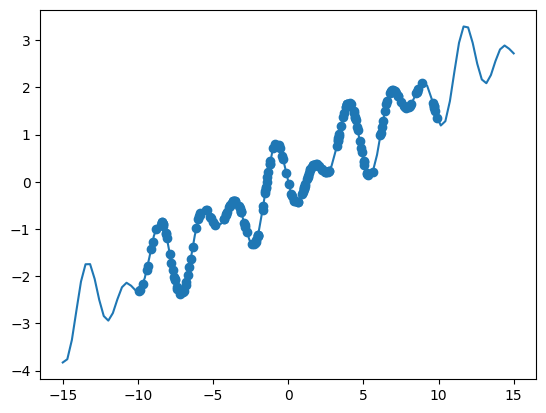

In [2]:
# The true function
np.random.seed(123)


def oscillator(x):
    return np.cos((x - 5) / 2) * np.sin(10 * x / 5) + x * 0.2


X = np.linspace(-15, 15, 100)[:, np.newaxis]
y = oscillator(X)  # Arrange outputs as feature columns

n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data)

plt.plot(X, y)
plt.scatter(X_data, y_data)
plt.show()

In [3]:
# Convert to dataframe
df = pd.DataFrame({"x": X_data, "y": y_data})
df.head()

,x,y
0,3.929384,1.645978
1,-4.277213,-0.799083
2,-5.462971,-0.597701
3,1.026295,-0.152890
4,4.389379,1.452048


In [4]:
# Define the name of the dataset
dataset_id = "ModelSelect_Data"

# Initialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset to the cloud
dataset.upload(df, verbose=True)

Dataframe is uploading.
Summarising dataset
Dataset summary created and saved.


### **GP without Model Selection**

For a fair comparison, we will want to run a standard GP with the ubiquitous Matern 5/2 kernel first.


In [5]:
# Initialise emulator
emulator_id = "BasicGP"

emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(train_test_ratio=0.75, estimator="gaussian_process_regression")

# Train the mulator using the train method
emulator.train(
    dataset=dataset, inputs=["x"], outputs=["y"], params=params, verbose=True
)

Emulator BasicGP has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator BasicGP is complete!


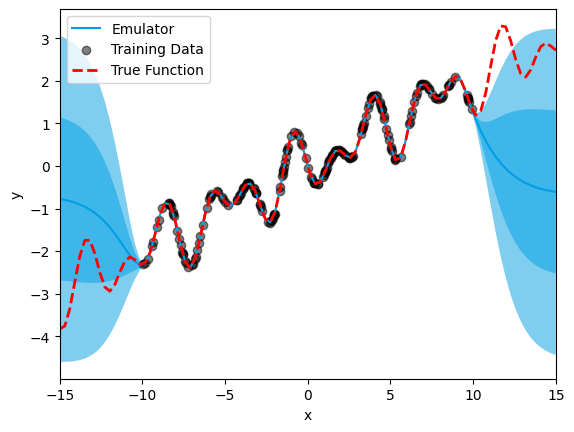

In [6]:
# Plot the results
plt = emulator.plot(x_axis="x", y_axis="y", x_lim=(-15, 15))
plt.scatter(df["x"], df["y"], alpha=0.5, label="Training Data", color="black")
plt.plot(X, y, c="r", linewidth=2, label="True Function", linestyle="dashed")
plt.legend()
plt.show()

### **GP with Model Selection**

Model selection in `twinlab` is exposed via the `'model_selection'=True` parameter in the `TrainParams` object. Additional parameters to control the model selection process can be passed to the `'model_selection_params'` parameter which accepts an instantiation of the `ModelSelectionParams` object.

`ModelSelectionParams` object contains all the parameters required for the model selection process. This includes `'depth'`, which controls the maximum number of compositional kernels to search for, and `'beam'`, which controls the number of successful trials carried between search iterations. `'beam'=1` corresponds to greedy search, and `'beam'=None` corresponds to grid search (this is the default, but will result in exponential computational complexity). It is highly recommended to also provide a `'seed'` keyword parameter to allow reproducibility.

Note that the model achieved by this process is no more _correct_ when compared to the basic model (as they are just different ways of describing the same data), however the model with automatic compositional kernel may have better extrapolation properties.


In [7]:
# Initialise emulator
emulator_id = "ModelSelectionGP"

model_selection_emulator = tl.Emulator(id=emulator_id)

# Define the model selction parameters
model_selection_params = tl.ModelSelectionParams(depth=3, beam=2, seed=123)

# Define the training parameters for your emulator
new_params = tl.TrainParams(
    model_selection=True,
    model_selection_params=model_selection_params,
    train_test_ratio=0.75,
    estimator="gaussian_process_regression",
)

# Train the mulator using the train method
model_selection_emulator.train(
    dataset=dataset, inputs=["x"], outputs=["y"], params=new_params, verbose=True
)

Emulator ModelSelectionGP has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:09: Job status: processing
0:00:12: Job status: processing
0:00:15: Job status: processing
0:00:18: Job status: processing
0:00:21: Job status: processing
0:00:25: Job status: processing
0:00:29: Job status: processing
0:00:34: Job status: processing
0:00:39: Job status: processing
0:00:44: Job status: success
Training of emulator ModelSelectionGP is complete!


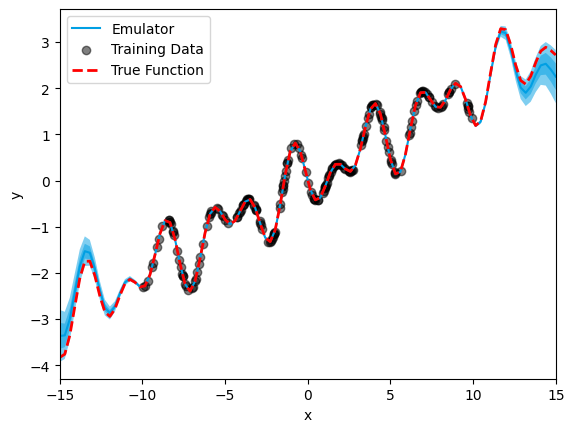

In [8]:
# Plot the results
plt = model_selection_emulator.plot(x_axis="x", y_axis="y", x_lim=(-15, 15))
plt.scatter(df["x"], df["y"], alpha=0.5, label="Training Data", color="black")
plt.plot(X, y, c="r", linewidth=2, label="True Function", linestyle="dashed")
plt.legend()
plt.show()

In [9]:
# Delete emulators and dataset
emulator.delete()
model_selection_emulator.delete()

dataset.delete()